In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
from scipy import stats
from statsmodels.stats.weightstats import zconfint, _tconfint_generic
import statsmodels.stats.api as sms
import matplotlib.pylab as plt

In [2]:
raw_data = pd.read_csv("data.csv", header=0, sep=",")

Проверим, содержатся ли в данных пропущенные значения. В случае если содержатся - введем бинарный признак отсутствия данных

In [3]:
print("Data has NAN values:", raw_data.isnull().values.any())

Data has NAN values: False


Отлично! Пропусков в данных нет, а это значит что нам не нужно будет делать предобработку

#   Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [4]:
def calculate_sigma(input_data: pd.Series):
    mean = input_data.mean()
    SSM = sum([(x - mean) ** 2 for x in input_data])
    return SSM / (len(input_data) - 1)

credit_returned = raw_data[raw_data["default"] == 0]
credit_dept = raw_data[raw_data["default"] == 1]
#   Для оценки медианных значений хочется понять можем ли мы использовать критерий Стьюдента?
#   Оценим выборочные дисперсии
print(f"RETURNED n = {credit_returned.shape[0]}, std^2 = {calculate_sigma(credit_returned['LIMIT_BAL'])}")
print(f"DEPT n = {credit_dept.shape[0]}, std^2 = {calculate_sigma(credit_dept['LIMIT_BAL'])}")
#   Выборка с большей дисперсией больше чем выборка с меньшей дисперсией. Можно применять критерий Стьюдента

RETURNED n = 23364, std^2 = 17326025066.91146
DEPT n = 6636, std^2 = 13312207624.358934


SELF MADE: 6.424018308502891e-179
SCIPY REALISATION: 3.3641002455114717e-178
BOOTSTRAP INTERVAL:
[60000. 70000.]


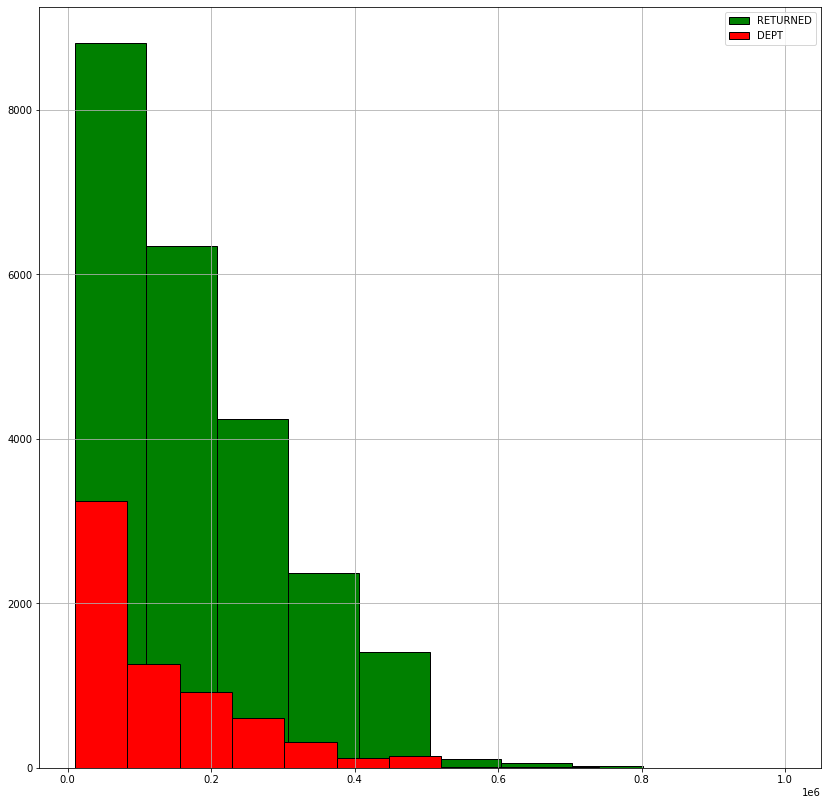

In [5]:
def get_bootstrap_interval(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_interval(stat, alpha=.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


#   Можно использовать stats.ttest_ind, но интересней снова написать self-made функцию
def definition_of_freedom_and_ttest_stat_2_samples(sample1: pd.Series, sample2: pd.Series):
    S1 = calculate_sigma(sample1)
    S2 = calculate_sigma(sample2)
    n1 = len(sample1)
    n2 = len(sample2)
    dof = (((S1 ** 2 / n1) + (S2 ** 2 / n2)) ** 2) / ((S1 ** 4 / ((n1 - 1) * n1 ** 2)) + (S2 ** 4 / ((n2 - 1) * n2 ** 2)))
    return dof, (sample1.mean() - sample2.mean())/ np.sqrt((S1 / n1) + (S2 / n2))


def ttest_mean_2_samples(sample1: pd.Series, sample2: pd.Series, alternative="two-sided"):
    if alternative not in ('two-sided', 'greater', 'less'):
        raise ValueError("Unknown alternative")

    dof, t_stat = definition_of_freedom_and_ttest_stat_2_samples(sample1, sample2)
    if alternative == "two-sided":
        return 2 * stats.t.sf(t_stat, dof)
    if alternative == "less":
        return stats.t.cdf(t_stat, dof)
    if alternative == "greater":
        return stats.t.sf(t_stat, dof)

print("SELF MADE:", ttest_mean_2_samples(credit_returned.LIMIT_BAL, credit_dept.LIMIT_BAL))
print("SCIPY REALISATION:", stats.ttest_ind(credit_returned.LIMIT_BAL, credit_dept.LIMIT_BAL, equal_var=False)[1])

plt.figure(figsize=(14,14))
plt.grid()
plt.hist(credit_returned.LIMIT_BAL, edgecolor="black", color="green", label="RETURNED")
plt.hist(credit_dept.LIMIT_BAL, edgecolor="black", color="red", label="DEPT")
plt.legend(loc="upper right")
plt.show()
print('BOOTSTRAP INTERVAL:')
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(list(map(np.median, get_bootstrap_interval(credit_dept.LIMIT_BAL.values, 10000))), list(map(np.median, get_bootstrap_interval(credit_returned.LIMIT_BAL.values, 10000))))))
print(stat_interval(delta_median_scores, .05))

### Task 1.1 ANS:
### В любом случае гипотезу о равенстве медианы кредитного рейтинга можно отвергнуть
### P_VALUE: 6.424018308502891e-179
Построим дополнительно 95% доверительный интервал для разности средних

#   Значимо! Так как сильно отличается разность средних

In [6]:
print(sms.CompareMeans(sms.DescrStatsW(credit_returned.LIMIT_BAL), sms.DescrStatsW(credit_dept.LIMIT_BAL)).tconfint_diff(alpha=0.05))
#   Значимо!

(44494.42598868728, 51485.71332085771)


In [7]:
#   Можно воспользоваться бутстрэпом
np.random.seed(0)
#stat_interval(list(map(np.median, get_bootstrap_interval(credit_returned.LIMIT_BAL.values, 1000))))
print("[{0[0]}, {0[1]}]".format(stat_interval(list(map(np.median, get_bootstrap_interval(credit_returned.LIMIT_BAL.values, 1000))))))
print("[{0[0]}, {0[1]}]".format(stat_interval(list(map(np.median, get_bootstrap_interval(credit_dept.LIMIT_BAL.values, 1000))))))
#   значимо!

[150000.0, 150000.0]
[80000.0, 90000.0]


О равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

  0%|          | 0/999 [00:00<?, ?it/s]

Create Random indexes:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute Mean:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.001

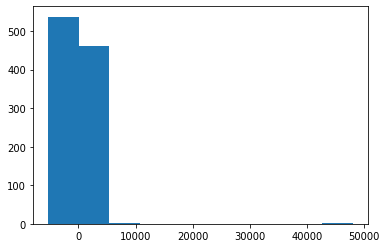

In [8]:
#   Можно воспользоваться готовым ранговых Манна-Уитни, а можно написать перестановочный критерий
def get_random_combinations(n1, n2, max_permutations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in tqdm(range(max_permutations - 1)):
        np.random.shuffle(index)
        indices.add(tuple(index))

    return [(index[:n1], index[n1:]) for index in tqdm(indices, desc="Create Random indexes")]


def permutation_zero_distribution(sample1: np.ndarray, sample2: np.ndarray, max_permutations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    if max_permutations:
        indices = get_random_combinations(n1, len(sample2), max_permutations=max_permutations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) for index in itertools.combinations(range(n), n1)]
    distribution = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() for i in tqdm(indices, desc="Compute Mean")]
    return distribution

def permutation_test(sample1: np.ndarray, sample2: np.ndarray, max_permutation=None, alternative="two-sided"):
    if alternative not in ("two-sided", 'less', 'greater'):
        raise ValueError("Unknown alternative")
    t_stat = np.mean(sample1) - np.mean(sample2)
    zero_distribution = permutation_zero_distribution(sample1, sample2, max_permutations=max_permutation)
    plt.hist(zero_distribution)
    if alternative == "two-sided":
        return sum([1 if abs(element) >= abs(t_stat) else 0 for element in tqdm(zero_distribution)]) / len(zero_distribution)
    if alternative == 'less':
        return sum([1 if element <= t_stat else 0 for element in zero_distribution]) / len(zero_distribution)
    if alternative == "greater":
        return sum([1 if element >= t_stat else 0 for element in zero_distribution]) / len(zero_distribution)


permutation_test(np.array(credit_returned.LIMIT_BAL), np.array(credit_dept.LIMIT_BAL), max_permutation=1000)

In [9]:
#   TASK 1.2
#   Воспользуемся критерием Манна-Уитни
stats.mannwhitneyu(credit_returned.LIMIT_BAL, credit_dept.LIMIT_BAL)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

#   TASK 1.2 ANS:

###   Распределения отличаются очень сильно (Например из критерия МАнна-Уитни гипотеза о совпадении распределений отвергается)
### Это практически значимо так как значительное различие между кредитным доверием
#   TASK 2
####    Фактически нас интересуют доли в двух независимых выборках. Составим таблицу сопряженности
|      X     | Мужчина | Женщина |
|:----------:|:-------:|:-------:|
|   Вернули  |   9015  |  14349  |
| Не вернули |   2873  |   3763  |

QUANTILE: (0.03363493274962867, 0.060548077974896725)
T-TEST: Ttest_indResult(statistic=6.926677006157904, pvalue=4.3952488032748674e-12)


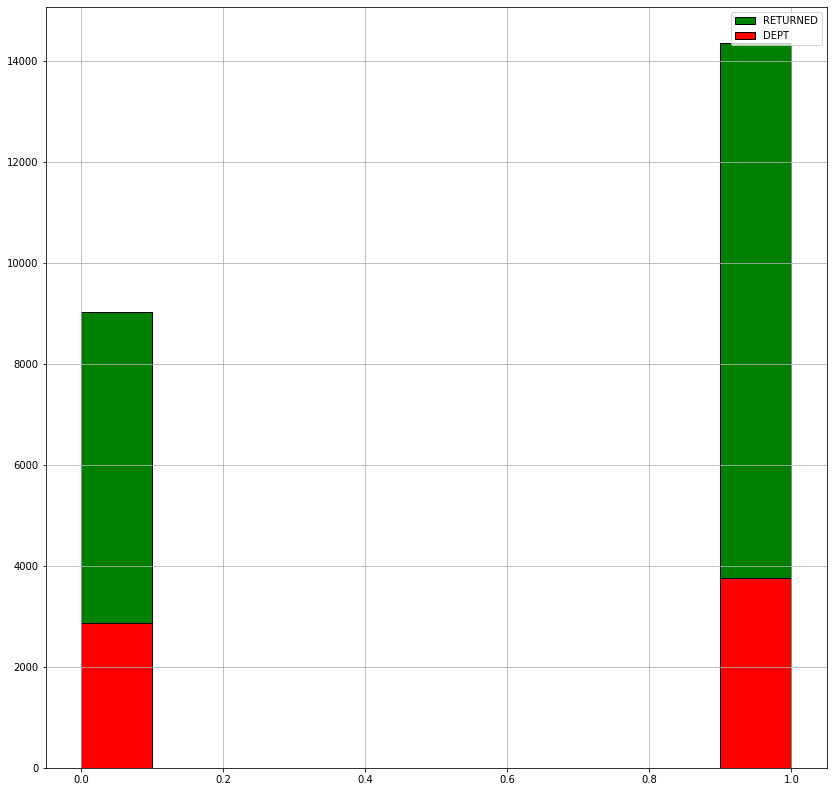

In [10]:
def quantile(sample1, sample2, alpha=.05):
    z_quantile = stats.norm.ppf(1 - alpha / 2.)
    n1 = len(sample1)
    n2 = len(sample2)
    p1 = sum(sample1) / n1
    p2 = sum(sample2) / n2
    add_subtraction = z_quantile * np.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
    return p1 - p2 - add_subtraction, p1 - p2 + add_subtraction

sample_1 = [0] * 9015 + [1] * 14349
sample_2 = [0] * 2873 + [1] * 3763
print('QUANTILE:', quantile(sample_1, sample_2))

print('T-TEST:', stats.ttest_ind(sample_1, sample_2))

plt.figure(figsize=(14,14))
plt.grid()
plt.hist(sample_1, edgecolor="black", color="green", label="RETURNED")
plt.hist(sample_2, edgecolor="black", color="red", label="DEPT")
plt.legend(loc="upper right")
plt.show()

#   TASK 2 ANS:

#   Доверительный интервал:
### (0.034, 0.061)
### P-VALUE очень мал, а значит гипотеза о равенстве долей отвергается (Критерий Стьюдента)

###   Да, состав отличается
#   Тут нужно поменять местами таблицу чтобы вышло так:


|      X     | Вернули | Нет |
|:----------:|:-------:|:-------:|
|   Мужчина  |   9015  |  2873  |
| Женщина |   14349  |   3763  |

Так просто будет понятней

### Task 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

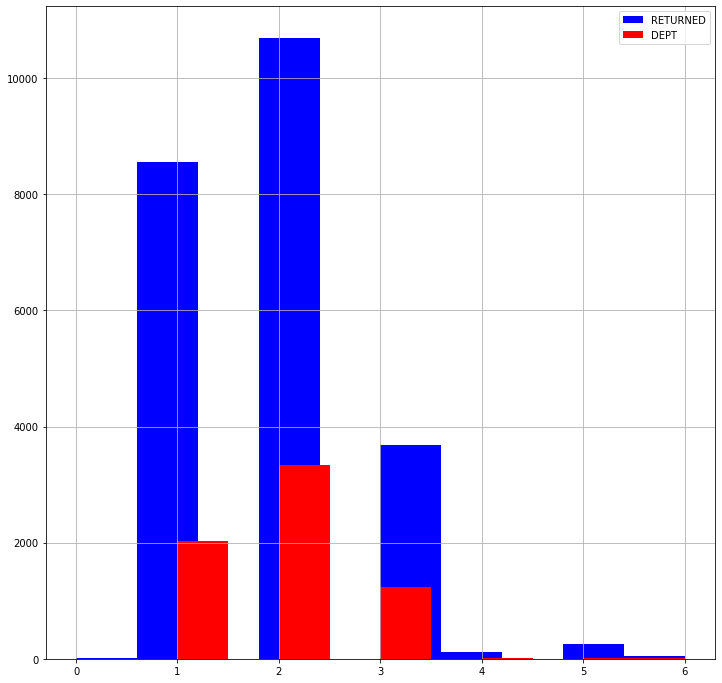

In [11]:
plt.figure(figsize=(12,12))
plt.grid()
plt.hist(credit_returned["EDUCATION"], color='b', label='RETURNED')
plt.hist(credit_dept["EDUCATION"], color='r', label="DEPT")
plt.legend(loc='upper right')
plt.show()

In [12]:
connected_matrix = pd.DataFrame(index=['Return', 'Dept'])

In [13]:
for age in raw_data["EDUCATION"].unique():
    default = sum(raw_data[raw_data["EDUCATION"] == age]["default"])
    connected_matrix.loc['Dept',f"age_{age}"] = int(default)
    connected_matrix.loc['Return',f"age_{age}"] = int(raw_data[raw_data["EDUCATION"] == age].shape[0] - default)

connected_matrix = connected_matrix.astype(int)
connected_matrix

,age_2,age_1,age_3,age_5,age_4,age_6,age_0
Return,10700,8549,3680,262,116,43,14
Dept,3330,2036,1237,18,7,8,0


In [14]:
#   Эта функция вычисляет хи-квадрат статистики и р-значение для проверки гипотезы о независимости наблюдаемых частот в таблице сопряженности
stats.chi2_contingency(connected_matrix.values, correction=False)
#   Гипотезу о независимости значений можно отвергнуть

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0926564e+04, 8.2435980e+03, 3.8293596e+03, 2.1806400e+02,
         9.5792400e+01, 3.9718800e+01, 1.0903200e+01],
        [3.1034360e+03, 2.3414020e+03, 1.0876404e+03, 6.1936000e+01,
         2.7207600e+01, 1.1281200e+01, 3.0968000e+00]]))

In [15]:
chi2_stat = stats.chi2_contingency(connected_matrix.values, correction=False)[0]
V_CRAMER = np.sqrt((chi2_stat / np.sum(connected_matrix.values)) / (min(connected_matrix.shape) - 1))
print(V_CRAMER)

0.07376009713252163


Составим таблицу сопряжённости "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

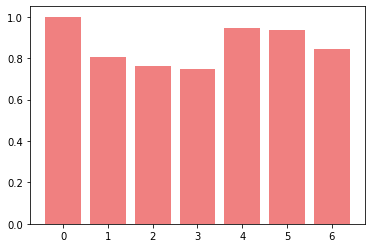

In [16]:
#   До этого построим график зависимости доли возвратов в зависимости от образования
average_mean = np.array(list())
for age in raw_data["EDUCATION"].unique():
    proportion = sum(raw_data[raw_data["EDUCATION"] == age]["default"]) /  raw_data[raw_data["EDUCATION"] == age].shape[0]
    plt.bar(int(age), height=(1 - proportion), color='lightcoral')
    average_mean = np.append(average_mean, 1 - proportion)
#   Видно что распределение не равномерное
#   Проверим это более строго

In [17]:
#   Из предположения независимости от образования посчитаем сначала средний ожидаемый возврат
education_return_proportion = average_mean.mean()
subtraction_dataframe = pd.DataFrame(index=['OBSERVATION', 'NORMAL'])
for i, age in enumerate(raw_data["EDUCATION"].unique()):
    not_default = raw_data[raw_data["EDUCATION"] == age].shape[0] - sum(raw_data[raw_data["EDUCATION"] == age]["default"])
    not_default_norm = int(raw_data[raw_data["EDUCATION"] == age].shape[0] * education_return_proportion)
    subtraction_dataframe.loc['OBSERVATION', f"age_{age}"] = not_default
    subtraction_dataframe.loc['NORMAL', f"age_{age}"] = not_default_norm
subtraction_dataframe

,age_2,age_1,age_3,age_5,age_4,age_6,age_0
OBSERVATION,10700.0,8549.0,3680.0,262.0,116.0,43.0,14.0
NORMAL,12107.0,9134.0,4243.0,241.0,106.0,44.0,12.0


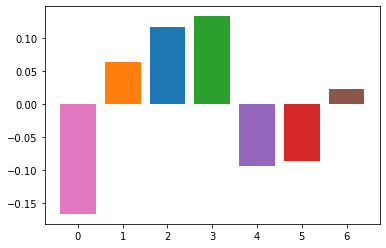

In [18]:
for column in subtraction_dataframe.columns:
    height = (subtraction_dataframe.loc["NORMAL", column] - subtraction_dataframe.loc["OBSERVATION", column]) / subtraction_dataframe.loc["NORMAL", column]
    plt.bar(int(column[4:]), height=height)

In [19]:
print('P-VALUE IS:', round(stats.chisquare(subtraction_dataframe.loc['OBSERVATION',:].values, subtraction_dataframe.loc['NORMAL',:].values, ddof=1)[1], 100))

P-VALUE IS: 3.5803812280614125e-58


### Task 3 ANS:
#   Гипотеза о том что величина имеет равномерное распределение, отвергается, так как обладает очень низким уровнем значимости.

#   Практически значимо так как образование кредитуемого влияет на возврат кредита

#   Лучше всего отдают кредит доктора наук, только что выпустившееся люди склонны не платить

### Task 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.
#### В данном случае удобно воспользоваться мерой крамера

In [20]:
marriage_info = [(0, 'SILENCE'), (1, "MARRIAGE"), (2, "SINGLE"), (3, "NODATA")]
marriage_df = pd.DataFrame(index=["RETURN", "DEPT"])
for marriage_status in marriage_info:
    data = raw_data[raw_data["MARRIAGE"] == marriage_status[0]]
    marriage_df.loc["RETURN", marriage_status[1]] = data.shape[0] - sum(data["default"])
    marriage_df.loc["DEPT", marriage_status[1]] = sum(data["default"])

marriage_df = marriage_df.astype(int)
marriage_df

,SILENCE,MARRIAGE,SINGLE,NODATA
RETURN,49,10453,12623,239
DEPT,5,3206,3341,84


In [21]:
chi2_stat = stats.chi2_contingency(marriage_df.values, correction=False)[0]
V_CRAMER = np.sqrt((chi2_stat / np.sum(marriage_df.values)) / (min(marriage_df.values.shape) - 1))
print(V_CRAMER)

0.034478203662766466


### Task 4 ANS:
Значение коэффициента крамера близко к нулю, что значит что взаимосвязь слабая.

Тем не менее, практическая значимость высокая, так как мы можем сделать вывод, что семейное положение не влияет на риск невозврата

### Task 5 аналогично пункту 1

  0%|          | 0/999 [00:00<?, ?it/s]

Create Random indexes:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute Mean:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.017

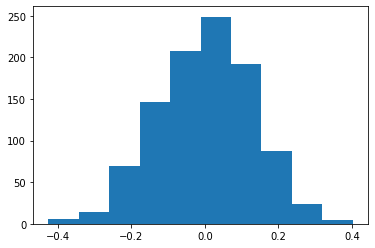

In [22]:
permutation_test(credit_returned.AGE, credit_dept.AGE, max_permutation=1000)

In [23]:
print("[{0[0]}, {0[1]}]".format(stat_interval(list(map(np.median, get_bootstrap_interval(credit_returned.AGE.values, 1000))))))
print("[{0[0]}, {0[1]}]".format(stat_interval(list(map(np.median, get_bootstrap_interval(credit_dept.AGE.values, 1000))))))

[34.0, 34.0]
[34.0, 35.0]


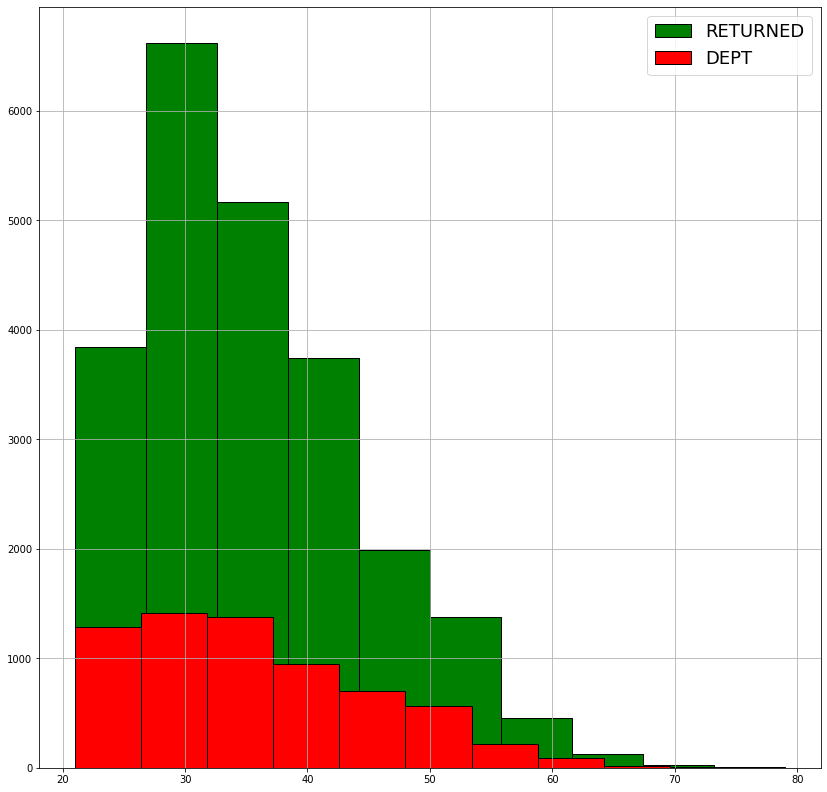

In [24]:
plt.figure(figsize=(14,14))
plt.grid()
plt.hist(credit_returned.AGE, color='green', edgecolor='black', label='RETURNED')
plt.hist(credit_dept.AGE, color="red", edgecolor='black', label='DEPT')
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [25]:
#   Построим доверительный интервал для разности медиан
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(list(map(np.median, get_bootstrap_interval(credit_dept.AGE.values, 1000))), list(map(np.median, get_bootstrap_interval(credit_returned.AGE.values, 1000))))))
print(stat_interval(delta_median_scores, .05))
#   0 содержится, значит разности медиан не различаются

[-1.  0.]


#   Task 5.1 ANS:
#   0 содержится, значит разности медиан не различаются
### Проверим теперь, отличаются ли распределения

  0%|          | 0/999 [00:00<?, ?it/s]

Create Random indexes:   0%|          | 0/1000 [00:00<?, ?it/s]

Compute Mean:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.013

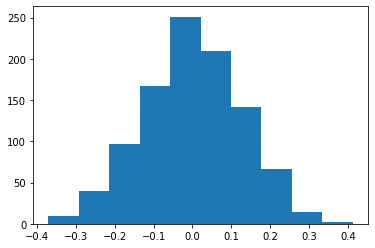

In [26]:
permutation_test(credit_returned.AGE, credit_dept.AGE, max_permutation=1000)

#   Task 5.2 ANS:
p_value получился маленьким. На уровне значимости 0.05 можно отвергнуть гипотезу о том, что распределения выборок одинаковые

Наблюдение значимо, так как может учитываться при выдачи кредита